In [1]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
%matplotlib inline
# all the basic libraries that we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style= 'darkgrid')

# pre-processing method
from sklearn.model_selection import train_test_split

# the regression models 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# methods and classes for evaluation
from sklearn import metrics
from math import sqrt
from sklearn.model_selection import cross_validate
import time

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Ensemble Techniques/Week2/resale+flat+prices+singapore.csv')  # import the csv file
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50432 entries, 0 to 50431
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                50432 non-null  object 
 1   town                 50432 non-null  object 
 2   flat_type            50432 non-null  object 
 3   block                50432 non-null  object 
 4   street_name          50432 non-null  object 
 5   storey_range         50432 non-null  object 
 6   floor_area_sqm       50432 non-null  float64
 7   flat_model           50432 non-null  object 
 8   lease_commence_date  50432 non-null  int64  
 9   remaining_lease      50432 non-null  object 
 10  resale_price         50432 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 4.2+ MB


In [ ]:
df.isna().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


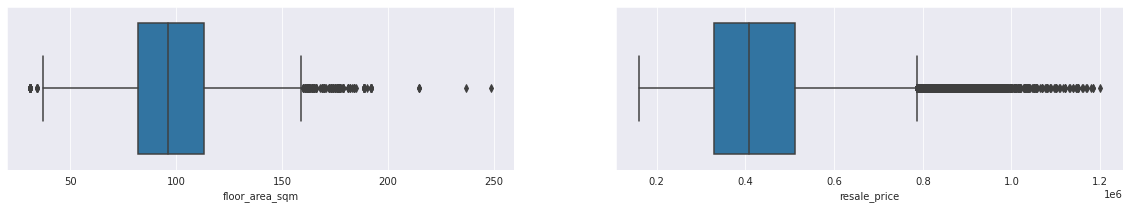

In [5]:
numeric_col = df.columns[pd.Series(df.columns).apply(lambda x : df[x].dtype == 'float64')]  # Non object columns

plt.figure(figsize = (20,3))

j = 1
for i in numeric_col:
    plt.subplot(1,2,j)
    sns.boxplot(df[i])
    j += 1

In [ ]:
from datetime import datetime
df.month = df.month.apply(lambda x: datetime.strptime(x, "%Y-%m"))    # Converting dtype of month column from object to datetime

TypeError: ignored

In [ ]:
remaining_years = df.remaining_lease.apply(lambda x: int(x[0:2])) #pull out numbers from individual strings of "remaining_lease"
lease_duration = (df.month.apply(lambda x: x.year) - df.lease_commence_date) + remaining_years
lease_duration.value_counts()
# All the leases seem to be 100year leases. So we need only one of the three columns["remaining_lease",
#                                                                                   "Lease_commence_date", "month"]

99     28579
98     21794
100       59
dtype: int64

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
encoded_df = pd.DataFrame()
object_col = df.columns[pd.Series(df.columns).apply(lambda x : df[x].dtype == 'O')] 
for i in df.columns:
    if i in object_col:
        encoded_df[i] = le.fit_transform(df[i])
    else:
        encoded_df[i] = df[i]

#Encode the categorical variables

In [7]:
encoded_df.dtypes

month                    int64
town                     int64
flat_type                int64
block                    int64
street_name              int64
storey_range             int64
floor_area_sqm         float64
flat_model               int64
lease_commence_date      int64
remaining_lease          int64
resale_price           float64
dtype: object

In [8]:
# convert data type of categorical columns as "category" type
for i in df.columns:
    if df[i].dtype == 'O':
        encoded_df[i] = encoded_df[i].astype('category')
    else:
        pass

In [9]:
encoded_df.dtypes

month                  category
town                   category
flat_type              category
block                  category
street_name            category
storey_range           category
floor_area_sqm          float64
flat_model             category
lease_commence_date       int64
remaining_lease        category
resale_price            float64
dtype: object

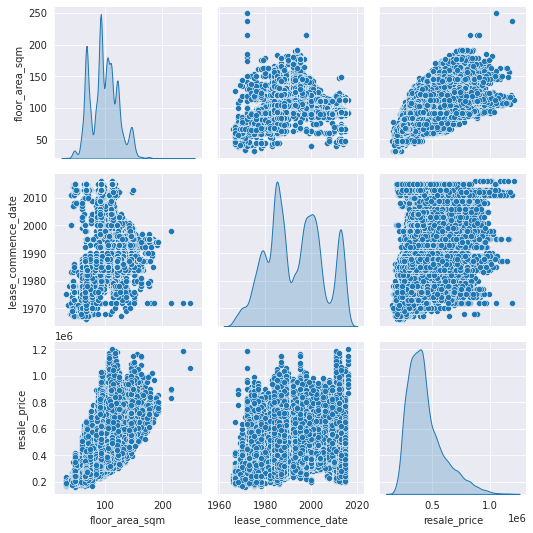

In [ ]:
sns.pairplot(df, diag_kind= 'kde')
plt.show()

In [ ]:
encoded_df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')

In [10]:
# drop "month" and "lease" along with the target column, because all are 100 year leases.
X = encoded_df.drop(columns= ['month', 'remaining_lease', 'resale_price'])
y = encoded_df.resale_price

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

In [12]:
def fit_n_print(model, X_train, X_test, y_train, y_test):  # take the model, train data and test data as input
    
    start = time.time()  # note the start time 

    model.fit(X_train, y_train)   # fit the model using the train data

    pred = model.predict(X_test)     # model predictions on the test data

    r2 = metrics.r2_score(y_test, pred)  # calculate the r squared value on the test data
    
    rmse = sqrt(metrics.mean_squared_error(y_test, pred))   # Root mean squared error
    
    rmsle = sqrt(metrics.mean_squared_log_error(y_test, pred))  # Root mean squared log error (since the numbers are huge)
    
    scorer = {'r2' : metrics.make_scorer(metrics.r2_score),
              'mse' : metrics.make_scorer(metrics.mean_squared_error),
              'msle' : metrics.make_scorer(metrics.mean_squared_log_error),
               }    # make scorers to be used in cross validation
    
    cv = cross_validate(model, X_train, y_train, cv=10, scoring = scorer)   # perform cross validation accross 3 metrics
    
    r2_cv = cv['test_r2'].mean()                                     # mean r squared value
    rmse_cv = np.mean([sqrt(mse) for mse in cv['test_mse']]) # mean RMSE value(take root of individual mse value and then mean)
    rmsle_cv = np.mean([sqrt(msle) for msle in cv['test_msle']]) # mean RMSLE
    
    end = time.time()  #note the end time
    
    
    duration = end - start  # calculate the total duration
    
    
    return r2, rmse, rmsle, r2_cv, rmse_cv, rmsle_cv, duration, pred  # return all the metrics along with predictions

In [13]:
lr = LinearRegression()        
dt = DecisionTreeRegressor(random_state=1)   
br = BaggingRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1, n_estimators=100)  # specifying n_estimators to avoid "future warnings"
gb = GradientBoostingRegressor(random_state=1, n_estimators=100)


result = {}   # Create an empty dictionary to later use to store metrics of each of the models

# putting all 5 models in a for loop and appending the results of each of the models to the 'result' dictionary
for model, name  in zip([lr, dt, br, rf, gb], ['Linear Regression', 'Decision Tree',
                                                    'Bagging Ensemble', 'Random Forest', 'Gradient Boost Ensemble']):
    result[name] = fit_n_print(model,X_train, X_test,y_train, y_test)  
    # store all the metrics in the result dict, with name as key
   
    

In [ ]:
result1 = pd.DataFrame(np.array(list(result.values()))[:,:-1],    # make a dataframe out of the metrics from result dictionary 
                       columns= ['R Squared', 'MSE', 'MSLE', 'R2 CV', 'RMSE CV', 'RMSLE CV', 'Elapsed'],
                      index= result.keys())   # use the model names as index

result1.index.name = 'Model'   # name the index of the result1 dataframe as 'Model'

result1 

<ipython-input-32-c8ac17e37a6d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result1 = pd.DataFrame(np.array(list(result.values()))[:,:-1],    # make a dataframe out of the metrics from result dictionary


,R Squared,MSE,MSLE,R2 CV,RMSE CV,RMSLE CV,Elapsed
Model,,,,,,,
Linear Regression,0.572798,101139.480516,0.209603,0.573113,100452.953833,0.207289,0.821801
Decision Tree,0.937031,38829.935047,0.083684,0.936076,38863.937784,0.084249,3.1678
Bagging Ensemble,0.958115,31668.952268,0.069617,0.955902,32279.786023,0.070342,13.999854
Random Forest,0.960693,30678.664378,0.067732,0.959832,30812.718354,0.067747,141.54925
Gradient Boost Ensemble,0.832664,63299.325675,0.127729,0.839368,61623.848334,0.124478,37.264275


In [ ]:
cat_col = X.columns[pd.Series(X.columns).apply(lambda x : X[x].dtype.name == 'category')]   

# check the cardinality of the columns
for i in cat_col:
    print(i, "=>" ,len(X[i].value_counts()))  # print number of categories in each of the categorical columns
    

town => 26
flat_type => 7
block => 2299
street_name => 533
storey_range => 17
flat_model => 20


In [ ]:
one_hot_X = X.drop(columns= ['block', 'street_name']) # Because cardinality is high
one_hot_X = pd.get_dummies(one_hot_X, drop_first=True)
one_hot_X.shape

X_train, X_test, y_train, y_test = train_test_split(one_hot_X,y, random_state = 1) 

In [ ]:
lr = LinearRegression()        
dt = DecisionTreeRegressor(random_state=1)   
br = BaggingRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1, n_estimators=100)
gb = GradientBoostingRegressor(random_state=1, n_estimators=100)
xgb = XGBRegressor()
cgb = CatBoostRegressor()
lgb = LGBMRegressor()


result = {}   # Create an empty dictionary to later use to store metrics of each of the models

for model, name  in zip([lr, dt, br, rf,
                         gb, xgb, cgb, lgb], ['Linear Regression', 'Decision Tree','Bagging Ensemble', 'Random Forest',
                                              'Gradient Boost Ensemble', 'Xgboost', 'Catboost','LightGB']):
    result[name] = fit_n_print(model,X_train, X_test,y_train, y_test)  
    

Streaming output truncated to the last 5000 lines.
4:	learn: 127223.0692408	total: 28.8ms	remaining: 5.72s
5:	learn: 123171.8954001	total: 33.9ms	remaining: 5.62s
6:	learn: 119469.1012916	total: 38.7ms	remaining: 5.49s
7:	learn: 116036.3052088	total: 43.6ms	remaining: 5.41s
8:	learn: 112924.4107344	total: 48.3ms	remaining: 5.32s
9:	learn: 110117.3401170	total: 53ms	remaining: 5.25s
10:	learn: 107459.5470357	total: 58.2ms	remaining: 5.23s
11:	learn: 105088.4360962	total: 63.4ms	remaining: 5.22s
12:	learn: 102963.6771437	total: 69ms	remaining: 5.24s
13:	learn: 100889.2224358	total: 74.4ms	remaining: 5.24s
14:	learn: 98967.7181034	total: 79.8ms	remaining: 5.24s
15:	learn: 97042.5327930	total: 85.4ms	remaining: 5.25s
16:	learn: 95450.2708672	total: 90.2ms	remaining: 5.21s
17:	learn: 93946.8743411	total: 95.3ms	remaining: 5.2s
18:	learn: 92437.4838370	total: 100ms	remaining: 5.19s
19:	learn: 91032.8692496	total: 105ms	remaining: 5.16s
20:	learn: 89694.0613966	total: 110ms	remaining: 5.15s
2

In [ ]:
result_df = pd.DataFrame(result).T.iloc[:,:-1]

result_df.columns = ['R squared', 'RMSE', 'RMSLE', 'CV R squared', 'CV RMSE', 'CV RMSLE', 'Elapsed']
result_df

,R squared,RMSE,RMSLE,CV R squared,CV RMSE,CV RMSLE,Elapsed
Linear Regression,0.864321,56998.15831,0.144925,0.867013,56072.344342,0.141419,3.710186
Decision Tree,0.930057,40923.692222,0.087009,0.930186,40624.552422,0.086537,3.102337
Bagging Ensemble,0.940358,37790.255616,0.081284,0.941928,37050.418028,0.080257,22.443089
Random Forest,0.943313,36842.293733,0.079518,0.944468,36229.33898,0.07874,191.453768
Gradient Boost Ensemble,0.846007,60723.128228,0.125164,0.84818,59905.577944,0.12346,53.659708
Xgboost,0.8459,60744.247665,0.124982,0.846918,60153.16999,0.123955,59.661994
Catboost,0.938566,38353.729855,0.082949,0.938791,38038.896895,0.08233,70.545152
LightGB,0.9253,42292.464596,0.089621,0.926028,41819.735462,0.088693,4.87447


<ipython-input-37-1f9823c39814>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(np.array(list(result.values()))[:,-1][pos-1], y_test, alpha= 0.5, edgecolors='white')
<ipython-input-37-1f9823c39814>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.text(0, 0, f'{list(result.keys())[pos-1]}_R_squared = {round(np.array(list(result.values()))[:,0][pos-1], 3)}',


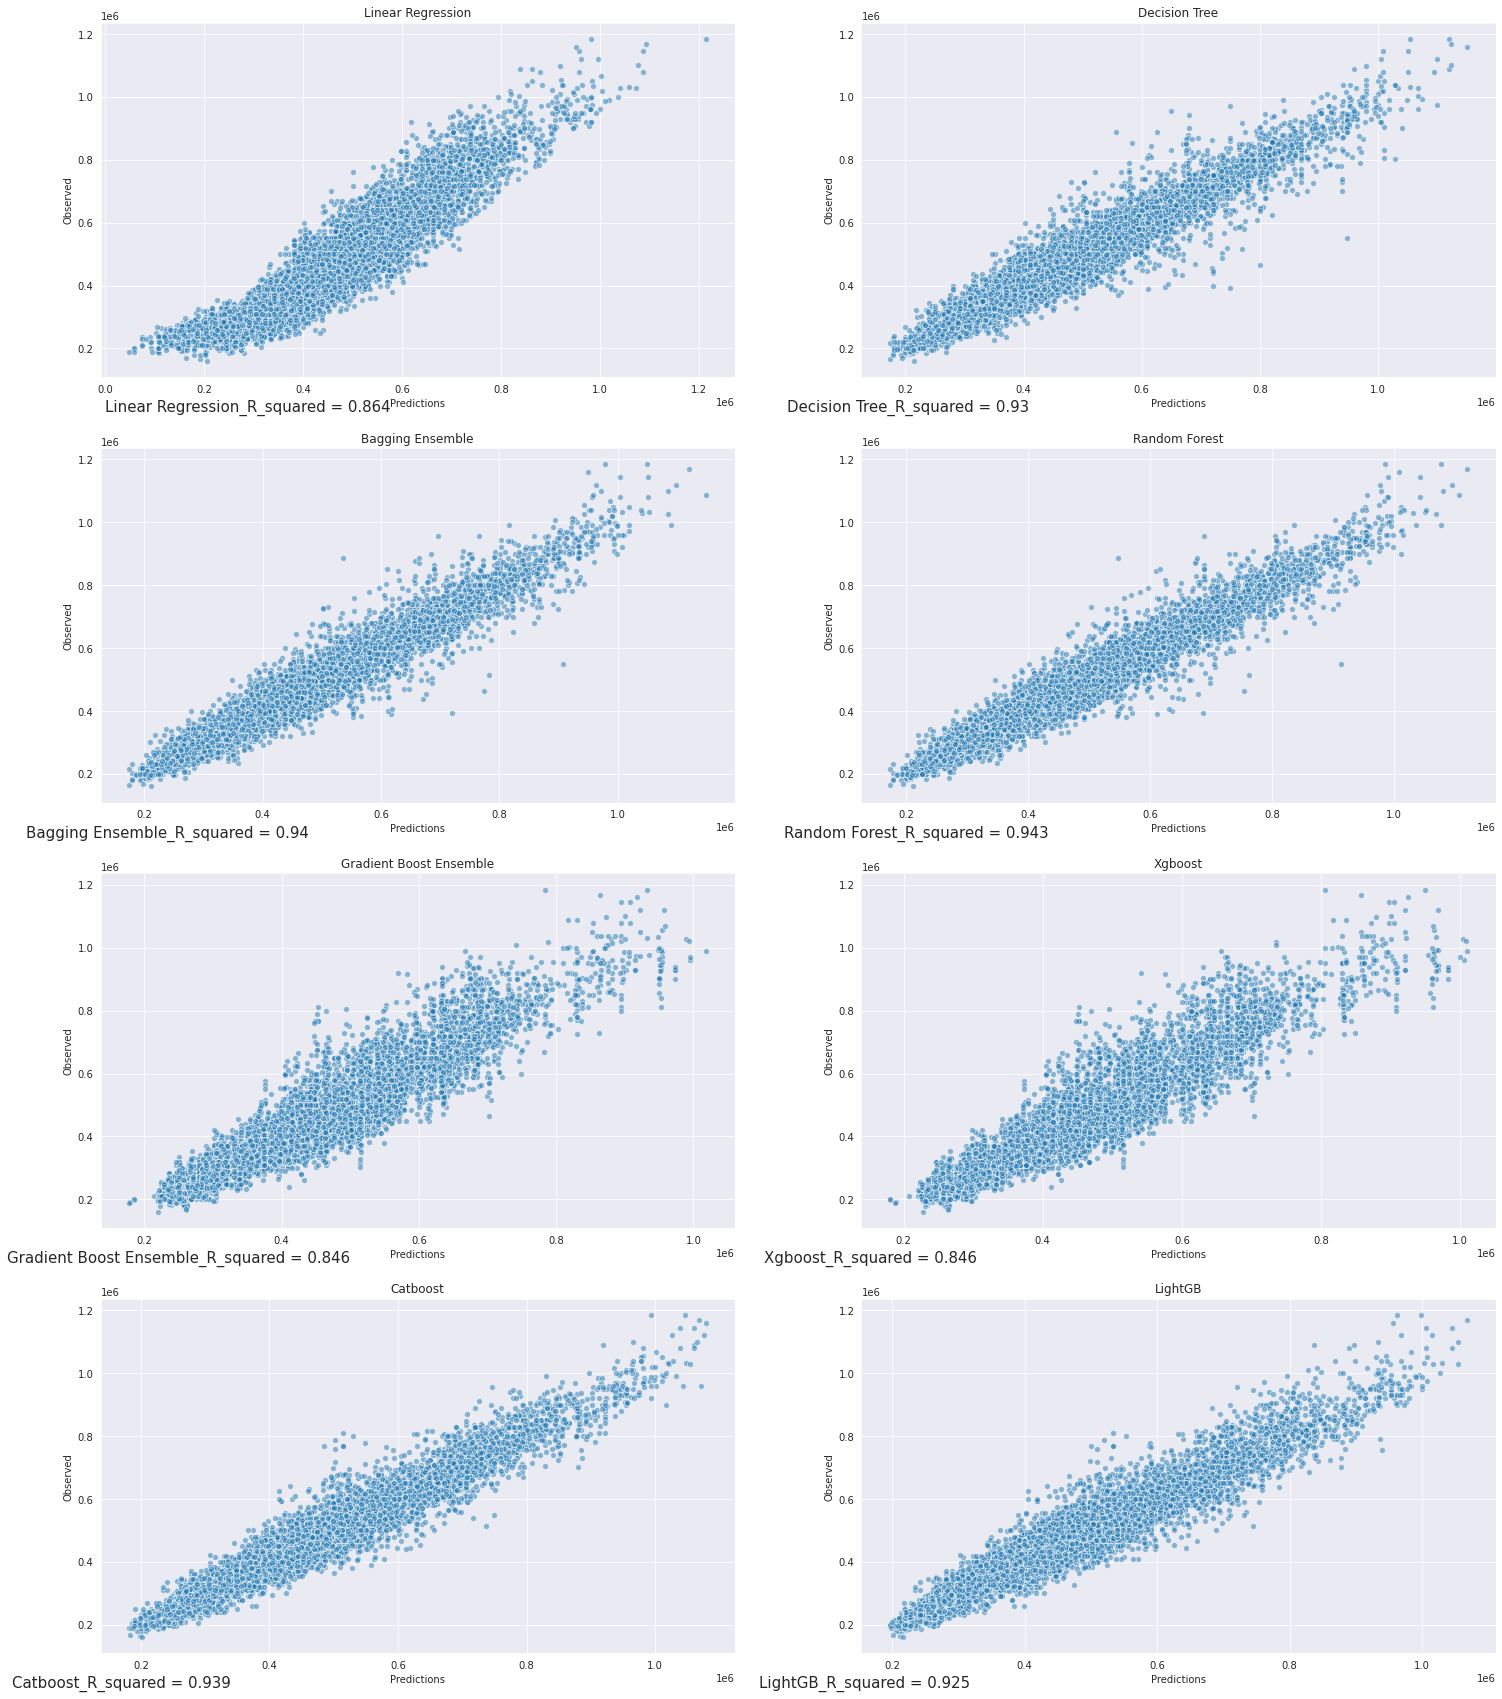

In [ ]:
plt.figure(figsize= (25,30))

for pos in range(1,9):
    plt.subplot(4, 2, pos)
    plt.scatter(np.array(list(result.values()))[:,-1][pos-1], y_test, alpha= 0.5, edgecolors='white')
    plt.xlabel('Predictions')
    plt.ylabel('Observed')
    plt.title(list(result.keys())[pos-1])
    plt.text(0, 0, f'{list(result.keys())[pos-1]}_R_squared = {round(np.array(list(result.values()))[:,0][pos-1], 3)}',
             fontsize = 15)
    pos += 1
    